<a href="https://colab.research.google.com/github/leocaricchio/ProjetoPIMAG/blob/main/Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1-Importação de bibliotecas

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches #Função para desenhar retângulos (bounding boxes)
from skimage.color import rgb2hsv

##2-Funções de Morfologia aplicadas manualmente

In [34]:
def manual_erosion(binary_img, kernel_size=3):
    rows, cols = binary_img.shape
    pad = kernel_size // 2
    padded = np.pad(binary_img, pad, mode='constant', constant_values=0)
    output = np.zeros_like(binary_img)
    for i in range(rows):
        for j in range(cols):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            if np.all(region): output[i, j] = 1
    return output

def manual_dilation(binary_img, kernel_size=3):
    rows, cols = binary_img.shape
    pad = kernel_size // 2
    padded = np.pad(binary_img, pad, mode='constant', constant_values=0)
    output = np.zeros_like(binary_img)
    for i in range(rows):
        for j in range(cols):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            if np.any(region): output[i, j] = 1
    return output

##3-Algoritmo flood fill implementado manualmente

In [35]:
#Função para detectar regiões conectadas(possíveis Jogadores/Árbitros)
#Para cada região encontrada:Calcula sua área e Obtém o retângulo delimitador para,posteriormente,desenhar o bounding box
def encontrar_objetos_manualmente(mask, min_area, max_area):
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    objetos = []
    vizinhos = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for y in range(rows):
        for x in range(cols):
            if mask[y, x] and not visited[y, x]:
                min_y, max_y, min_x, max_x = y, y, x, x
                stack = [(y, x)]
                visited[y, x] = True
                pixel_count = 0
                while stack:
                    cy, cx = stack.pop()
                    pixel_count += 1
                    if cy < min_y: min_y = cy
                    if cy > max_y: max_y = cy
                    if cx < min_x: min_x = cx
                    if cx > max_x: max_x = cx
                    for dy, dx in vizinhos:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < rows and 0 <= nx < cols:
                            if mask[ny, nx] and not visited[ny, nx]:
                                visited[ny, nx] = True
                                stack.append((ny, nx))

                if pixel_count > min_area and pixel_count < max_area:
                    h = max_y - min_y + 1
                    w = max_x - min_x + 1
                    objetos.append((min_y, min_x, h, w))
    return objetos


##4-Carregamento e Visualização da imagem

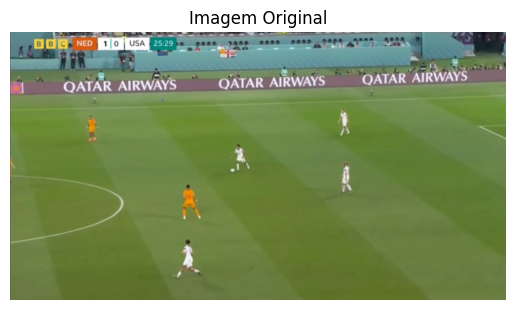

In [36]:
arquivo_imagem = '/content/Captura de tela 2026-02-11 224350.png'

try:
    img_original =imread(arquivo_imagem)
except FileNotFoundError:
    print("Erro no arquivo")
    img_original = np.zeros((400, 600, 3))

# Remove canal alpha
if img_original.shape[2] == 4:
    img_original = img_original[:, :, :3]

# Normaliza para o intervalo [0,1]
if img_original.max() > 1:
    img_original = img_original / 255.0

plt.imshow(img_original)
plt.title("Imagem Original")
plt.axis('off')
plt.show()


##5-Segmentação do campo usando HSV

In [37]:
#Conversão da imagem para HSV
img_hsv = rgb2hsv(img_original)

#Máscara do campo (verde)
mask_campo = (
    (img_hsv[:,:,0] > 0.20) &
    (img_hsv[:,:,0] < 0.45) &
    (img_hsv[:,:,1] > 0.2) &
    (img_hsv[:,:,2] > 0.2)
)

#Daqui em diante,só considera o que não se enquadra na máscara do campo
mask_objetos = ~mask_campo


##6-Definição da Região que usaremos para localizar os jogadores

In [38]:
#Filtro ainda maior da região a ser explorada
rows, cols = mask_objetos.shape

#Remove região superior da imagem(Torcida)
corte_topo = int(rows * 0.05)
mask_objetos[0:corte_topo, :] = 0

#Remove bordas da imagem
mask_objetos[-10:, :] = 0
mask_objetos[:, 0:5] = 0
mask_objetos[:, -5:] = 0


##7-Aplicação da Morfologia Matemática

In [39]:
#Remove ruídos pequenos
mask_limpa = manual_erosion(mask_objetos, kernel_size=2)

#Conecta partes do corpo dos jogadores
mask_fechada = manual_dilation(mask_limpa, kernel_size=6)

#Ajusta o tamanho novamente
mask_final = manual_erosion(mask_fechada, kernel_size=4)

##8-Detecção e Filtragem geométrica

In [40]:
#Uso de Critérios e Heurísticas para filtrar apenas os objetos detectados que representem Jogadores/Árbitros

objetos_brutos = encontrar_objetos_manualmente(mask_final, 30, 8000)
objetos_finais = []

for (y, x, h, w) in objetos_brutos:
    aspect_ratio = h / float(w) #Precisa ter mais altura que largura
    pixel_area = h * w #Area do Retangulo

    eh_vertical = aspect_ratio > 0.55
    tem_tamanho = h > rows * 0.03 #Tamanho mínimo
    nao_eh_linha = w < cols * 0.08 #Não ser muito largo(linha do campo)

    if eh_vertical and tem_tamanho and nao_eh_linha:
        objetos_finais.append((y, x, h, w))


##9-Visualização do Resultado final

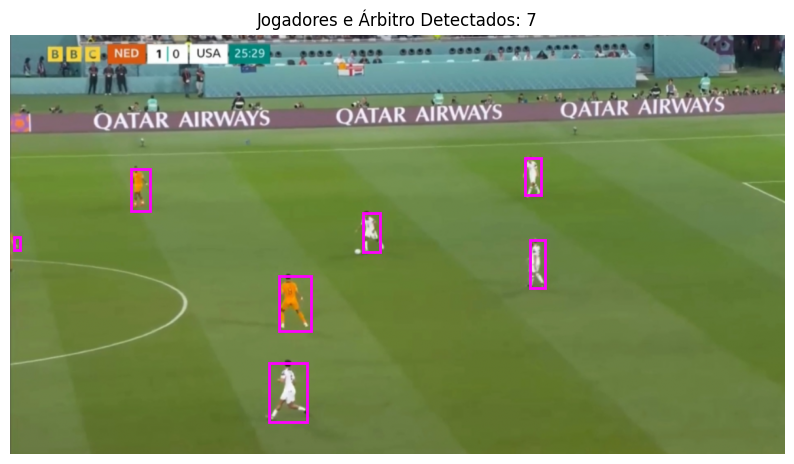

In [41]:
plt.figure(figsize=(10,6))
plt.imshow(img_original)

#Contagem dos Jogadores e Árbitros detectados
plt.title(f"Jogadores e Árbitro Detectados: {len(objetos_finais)}")

#Desenho dos bounding boxes sob as regiões detectadas
for (y, x, h, w) in objetos_finais:
    rect = patches.Rectangle((x, y), w, h,
                             linewidth=2,
                             edgecolor='magenta',
                             facecolor='none')
    plt.gca().add_patch(rect)

plt.axis('off')
plt.show()
